## Fashion-Mnist Playground

In [290]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageOps

from main import FashionMNISTCNN

In [291]:
train_dataset = torchvision.datasets.FashionMNIST(root="~/datasets", train=True, download=True)

#### Dataset Label Visualization

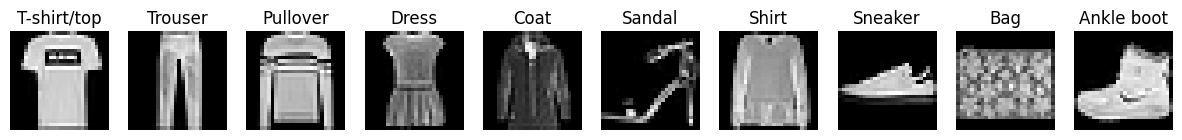

In [292]:
# collect image for each label
label_names = train_dataset.classes
label_images = [None for _ in range(10)]

count = 0
for image, label in train_dataset:
    if label_images[label] is None:
        label_images[label] = np.array(image)
        count += 1
    if count == len(label_images):
        break

# plot the images
fig, axes = plt.subplots(1, len(label_images), figsize=(15, 15))
for i, ax in enumerate(axes):
    ax.imshow(label_images[i].squeeze(), cmap="gray")
    ax.set_title(f"{label_names[i]}")
    ax.axis("off")

save_dir = os.path.join(os.getcwd(), "assets")
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, "dataset_image.png"), bbox_inches="tight")

#### Load Model for Evaluation

In [293]:
model = FashionMNISTCNN(input_channels=1, num_classes=10, activation=F.relu)
ck_path = os.path.join("assets", "pre_trained_models", "cnn_relu.pth")
state_dict = torch.load(ck_path)
model.load_state_dict(state_dict["model"])
model.eval()

C:\Users\DELL\AppData\Local\Temp\ipykernel_14216\693681970.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ck_path)


FashionMNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

#### Real World Model Evaluation

In [294]:
real_world_data_dir = os.path.join("assets", "real_world_data")

image_batch = []
for image_name in os.listdir(real_world_data_dir):
    image_path = os.path.join(real_world_data_dir, image_name)
    img = Image.open(image_path)
    img = img.convert("L").resize((28, 28))
    img = ImageOps.invert(img)
    img = np.array(img)
    image_batch.append(img)

image_batch = transforms.Normalize((0.5,), (0.5,))(torch.FloatTensor(image_batch).unsqueeze(1) / 255)

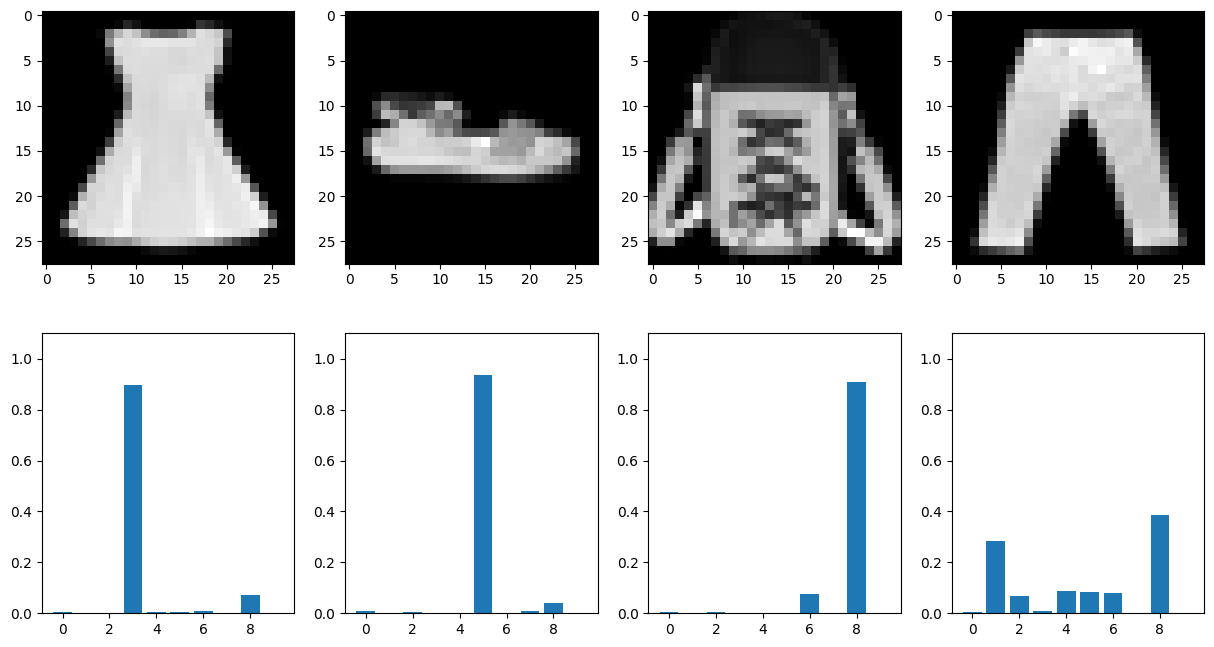

In [295]:
with torch.no_grad():
    probs = torch.softmax(model(image_batch), dim=-1)
    preds = torch.argmax(probs, dim=-1)

fig, axes = plt.subplots(2, len(image_batch), figsize=(15, 8))
for image_i, image in enumerate(image_batch):
    axes[0][image_i].imshow(image.squeeze(), cmap="gray")
    axes[1][image_i].bar(np.arange(10), probs[image_i].numpy())
    axes[1][image_i].set_ylim(0, 1.1)

#### Understanding impact of Image Rotation on Model

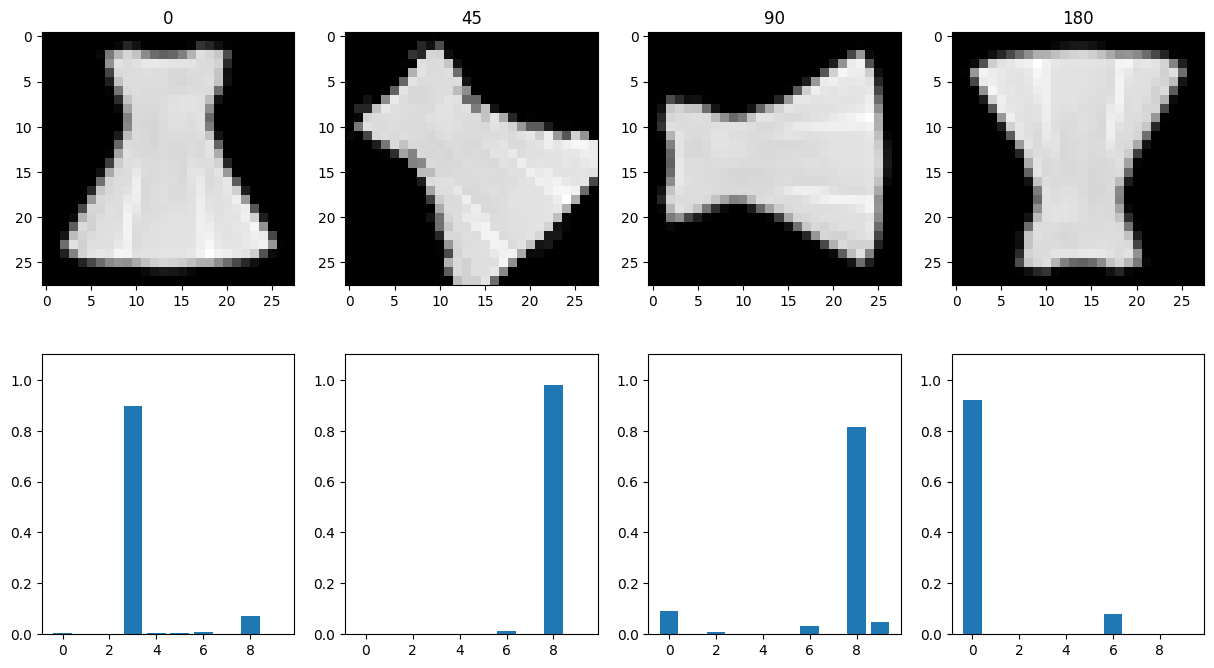

In [296]:
# load images and rotate them
real_world_data_dir = os.path.join("assets", "real_world_data")
image_path = os.path.join(real_world_data_dir, "dress.png")
image_batch = []
rotations = [0, 45, 90, 180]
for rotation in rotations:
    img = Image.open(image_path)
    img = img.convert("L").resize((28, 28))
    img = ImageOps.invert(img)
    img = img.rotate(rotation)
    img = np.array(img)
    image_batch.append(img)
image_batch = transforms.Normalize((0.5,), (0.5,))(torch.FloatTensor(image_batch).unsqueeze(1) / 255)

# evaluate the model
with torch.no_grad():
    probs = torch.softmax(model(image_batch), dim=-1)
    preds = torch.argmax(probs, dim=-1)

fig, axes = plt.subplots(2, len(image_batch), figsize=(15, 8))
for image_i, image in enumerate(image_batch):
    axes[0][image_i].imshow(image.squeeze(), cmap="gray")
    axes[1][image_i].bar(np.arange(10), probs[image_i].numpy())
    axes[1][image_i].set_ylim(0, 1.1)
    # add title
    axes[0][image_i].set_title(rotations[image_i])

#### Understanding impact of Image Noise

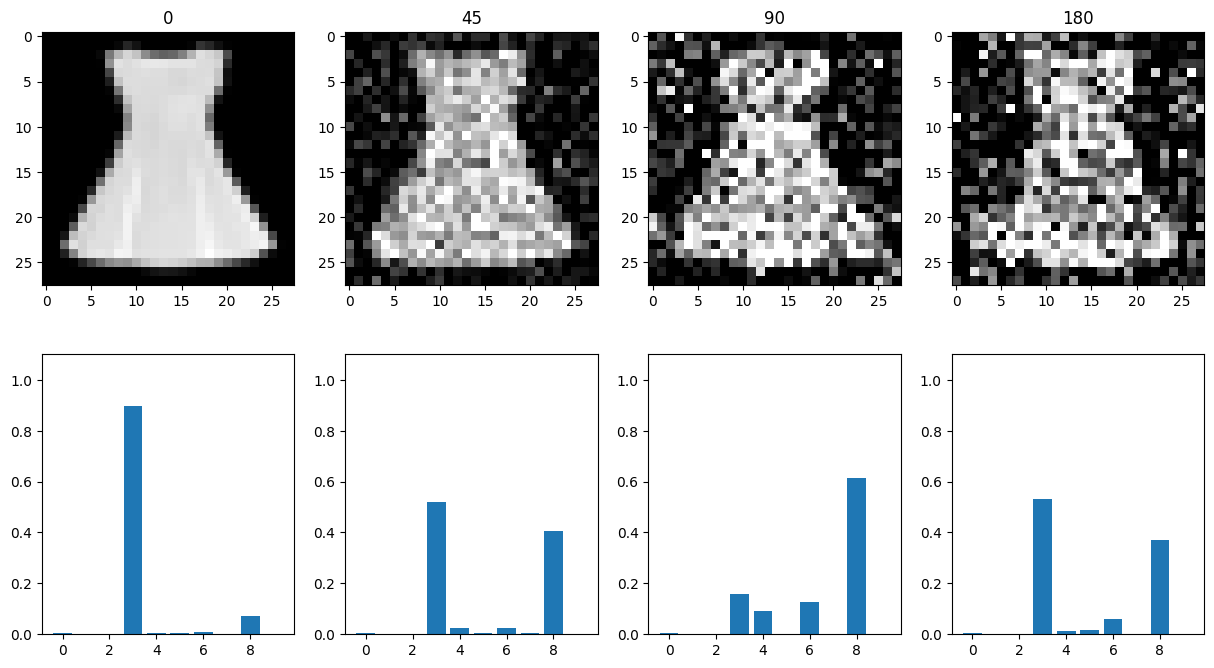

In [297]:
# load images and rotate them
real_world_data_dir = os.path.join("assets", "real_world_data")
image_path = os.path.join(real_world_data_dir, "dress.png")
image_batch = []
noise_scales = [0, 45, 90, 100]
for noise_scale in noise_scales:
    img = Image.open(image_path)
    img = img.convert("L").resize((28, 28))
    img = ImageOps.invert(img)

    # add noise
    img = np.array(img)
    noise = noise_scale * np.random.randn(*img.shape)
    img = np.clip(img + noise, 0, 255)

    image_batch.append(img)
image_batch = transforms.Normalize((0.5,), (0.5,))(torch.FloatTensor(image_batch).unsqueeze(1) / 255)

# evaluate the model
with torch.no_grad():
    probs = torch.softmax(model(image_batch), dim=-1)
    preds = torch.argmax(probs, dim=-1)

fig, axes = plt.subplots(2, len(image_batch), figsize=(15, 8))
for image_i, image in enumerate(image_batch):
    axes[0][image_i].imshow(image.squeeze(), cmap="gray")
    axes[1][image_i].bar(np.arange(10), probs[image_i].numpy())
    axes[1][image_i].set_ylim(0, 1.1)
    axes[0][image_i].set_title(rotations[image_i])

#### Understanding Impact of Color Inversion

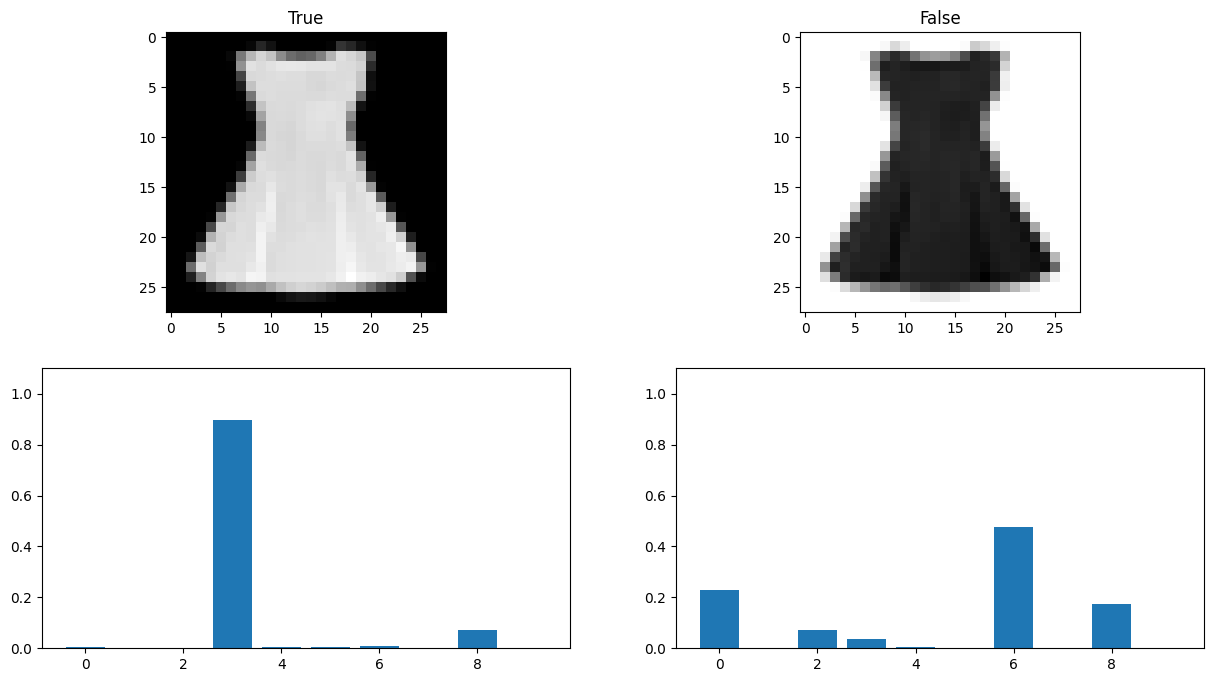

In [298]:
# load images and rotate them
real_world_data_dir = os.path.join("assets", "real_world_data")
image_path = os.path.join(real_world_data_dir, "dress.png")
image_batch = []
inversions = [True, False]
for inversion in inversions:
    img = Image.open(image_path)
    img = img.convert("L").resize((28, 28))
    if inversion:
        img = ImageOps.invert(img)
    img = np.array(img)
    image_batch.append(img)
image_batch = transforms.Normalize((0.5,), (0.5,))(torch.FloatTensor(image_batch).unsqueeze(1) / 255)

# evaluate the model
with torch.no_grad():
    probs = torch.softmax(model(image_batch), dim=-1)
    preds = torch.argmax(probs, dim=-1)

fig, axes = plt.subplots(2, len(image_batch), figsize=(15, 8))
for image_i, image in enumerate(image_batch):
    axes[0][image_i].imshow(image.squeeze(), cmap="gray")
    axes[1][image_i].bar(np.arange(10), probs[image_i].numpy())
    axes[1][image_i].set_ylim(0, 1.1)
    axes[0][image_i].set_title(inversions[image_i])

#### Understanding Impact of Image Cropping

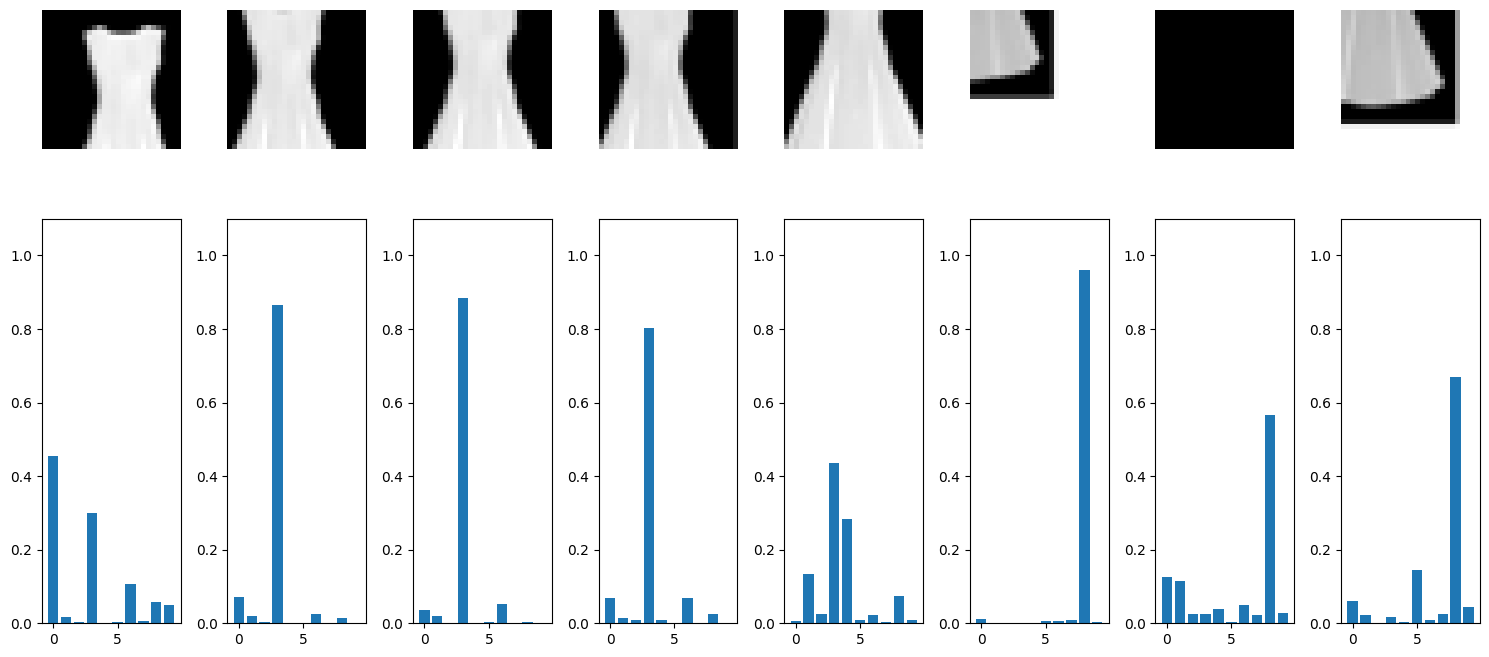

In [299]:
# Load images and process them
real_world_data_dir = os.path.join("assets", "real_world_data")
image_path = os.path.join(real_world_data_dir, "dress.png")
image_batch = []

# Define cropping levels
initial_crop = 0
max_crop = 400  # Max crop size to be added
step_crop = 50  # Increase in cropping with each step
num_crops = (max_crop - initial_crop) // step_crop

for crop_idx in range(num_crops):
    img = Image.open(image_path)
    # Calculate increasing crop size
    crop_size = initial_crop + crop_idx * step_crop
    x = np.random.randint(0, crop_size + 1)
    y = np.random.randint(0, crop_size + 1)
    img = img.crop((x, y, x + 200, y + 200))
    img = img.convert("L").resize((28, 28))
    img = ImageOps.invert(img)
    img = np.array(img)
    image_batch.append(img)

# Normalize
image_batch = transforms.Normalize((0.5,), (0.5,))(torch.FloatTensor(image_batch).unsqueeze(1) / 255)

# evaluate the model
with torch.no_grad():
    probs = torch.softmax(model(image_batch), dim=-1)
    preds = torch.argmax(probs, dim=-1)

# Plot images and predictions
fig, axes = plt.subplots(2, len(image_batch), figsize=(15, 8))
for image_i, image in enumerate(image_batch):
    axes[0, image_i].imshow(image.squeeze(), cmap="gray")
    axes[0, image_i].axis("off")
    axes[1, image_i].bar(np.arange(10), probs[image_i].numpy())
    axes[1, image_i].set_ylim(0, 1.1)
plt.tight_layout()
plt.show()